In [1]:
%load_ext autoreload
%autoreload 2

%matplotlib inline
import sys
import os.path
import matplotlib.pyplot as plt
import matplotlib as mpl
#mpl.style.use('v2.0')
plt.style.use('ggplot')

import numpy as np
import pandas as pd
from tqdm import tqdm

#import os, sys
sys.path.append(os.path.dirname("../"))
sys.path.append(os.path.dirname("../../"))

from plugins.FaxDistiller import Distill

In [74]:
#from mltools.tfrio import TFRecordsIO

In [75]:
raw_file = "../data/FakeWaveform_raw/XENON1T-0-000000000-000000999-000001000.zip"
truth_file = "../data/FakeWaveform_truth.csv"
instructions_file = "../data/FakeWaveform.csv"

data_path = "/cfs/klemming/nobackup/j/jcalven/wavenet_data/"

### Load FAX raw data and distill down into useful parts

In [76]:
distiller = Distill(raw_file, truth_file, instructions_file)
#distiller.load(pulse_properties=True)

In [84]:
### Distill.get() returns iterator of distilled data for the event (objects of the Condensate() class)
event = distiller.get_test(1).__next__()
event = distiller.get_test(2).__next__()
event.get_event().head()

,baseline,channel,event_number,left,length,max_waveform_length,right,waveform
0,-3.382979,0,0,82764,158,158,82921,"[1.3829787234, -2.6170212766, 5.3829787234, -2..."
1,-2.361702,2,0,82646,284,284,82929,"[3.36170212766, 1.36170212766, -0.63829787234,..."
2,0.106383,3,0,82738,130,130,82867,"[-1.10638297872, 0.893617021277, -2.1063829787..."
3,-7.063830,4,0,82698,198,198,82895,"[1.06382978723, 5.06382978723, -0.936170212766..."
4,-5.127660,5,0,72794,100,100,72893,"[3.12765957447, 3.12765957447, 0.127659574468,..."


In [91]:
events = []
waveforms_in_channels = []
event_truths = []
event_instructions = []

n_events = 1000
counter = 1

for i, distilled_events in tqdm(enumerate(distiller.get_test(n_events))):
    
    #events.append(distilled_events.get_event())  # Retrieve pandas.DataFrame of event information
    waveforms_in_channels.append(distilled_events.get_waveforms_in_channels())  # Retrieve pandas.DataFrame 
                                                                                # of per channel reconstructed 
                                                                                # waveforms in the event
    event_truths.append(distilled_events.get_event_truth())  # Retrieve pandas.DataFrame of PAX truth information for event
    event_instructions.append(distilled_events.get_event_instructions())

101it [00:05, 19.69it/s]


### The way to retrieve distilled data

In [17]:
### Distill.get() returns iterator of distilled data for the event (objects of the Condensate() class)
event = distiller.get(1).__next__()
event.get_event().head()

,baseline,channel,event_number,left,length,max_waveform_length,right,waveform
0,-3.382979,0,0,82764,158,158,82921,"[1.3829787234, -2.6170212766, 5.3829787234, -2..."
1,-2.361702,2,0,82646,284,284,82929,"[3.36170212766, 1.36170212766, -0.63829787234,..."
2,0.106383,3,0,82738,130,130,82867,"[-1.10638297872, 0.893617021277, -2.1063829787..."
3,-7.063830,4,0,82698,198,198,82895,"[1.06382978723, 5.06382978723, -0.936170212766..."
4,-5.127660,5,0,72794,100,100,72893,"[3.12765957447, 3.12765957447, 0.127659574468,..."


In [6]:
print(event.__doc__)


        Class of distilled FAX events.
        
        Methods:
            : get_events() : Returns pandas.DataFrame with core information on pulses in the event.
            : get_waveforms_in_channel() : Returns pandas.DataFrame with reconstructed waveforms per
                                           channel (pmt) for the event.
            : get_event_truth() : Returns pandas.DataFrame with FAX truth information on the event
    


In [7]:
def format_event_data(waveforms, instructions):
    
    return dict(data = waveforms.values.astype(int),
                x = instructions["x"].values[0],
                y = instructions["y"].values[0],
                depth = instructions["depth"].values[0],
                s1_photons = instructions["s1_photons"].values[0],
                s2_electrons = instructions["s2_electrons"].values[0],
                event_number = instructions["instruction"].values[0])

### Loop over events and store distilled data for each event

In [9]:
events = []
waveforms_in_channels = []
event_truths = []
event_instructions = []

save_to_dir = "/cfs/klemming/nobackup/j/jcalven/wavenet_data/"
fax_file = "XENON1T-0-000000000-000000999-000001000"

n_events = 100
counter = 1

#tfr_io = TFRecordsIO()
#tfr_io.open_tfwriter_stream(filename=data_path + fax_file + "_{}_events.tfr".format(n_events))

for i, distilled_events in tqdm(enumerate(distiller.get(n_events))):
    
    events.append(distilled_events.get_event())  # Retrieve pandas.DataFrame of event information
    waveforms_in_channels.append(distilled_events.get_waveforms_in_channels())  # Retrieve pandas.DataFrame 
                                                                                # of per channel reconstructed 
                                                                                # waveforms in the event
    event_truths.append(distilled_events.get_event_truth())  # Retrieve pandas.DataFrame of PAX truth information for event
    event_instructions.append(distilled_events.get_event_instructions())
    
    #waveforms_in_channels = distilled_events.get_waveforms_in_channels()
    #event_instructions = distilled_events.get_event_instructions()
    
    # Preprocess the data for feeding to TFRecords
    #event_data = format_event_data(waveforms_in_channels, event_instructions)
    
    # Write data to TFRecords files
    #tfr_io.write(filename=data_path + "test_10_events.tfr", **event_data)
    #tfr_io.write(**event_data)
    
    #df = pd.read_pickle(filename)
    #key = os.path.basename(filename) # or choose another name
    #if i+1%100 == 0 or i == 0:
    #    print("Writing to hdf file {}...".format(counter))
    #    file_it = 100 * counter
    #    output_filename = save_to_dir + fax_file + "_" + str(file_it) + ".h5"
    #    counter += 1
    #waveforms_in_channels.to_hdf(output_filename, "waveforms_{}".format(i))
    #event_instructions.to_hdf(output_filename, "instructions_{}".format(i))
    
#tfr_io.close_tfwriter_stream()

100it [00:04, 24.30it/s]


In [11]:
event_truths[0]

,fax_truth_peak_id,event,g4_id,instruction,n_electrons,n_photons,peak_type,repetition,t_first_electron,t_first_photon,...,t_last_electron,t_last_photon,t_mean_electrons,t_mean_photons,t_sigma_electrons,t_sigma_photons,top_fraction,x,y,z
0,0,0,-1,0,16.0,379,s2,0,826638.620366,8.267593e+05,...,828324.404529,8.290946e+05,827641.784142,8.279530e+05,404.286682,410.426691,0.675462,4.517730,27.061374,-24.814994
1,1,0,-1,0,NaN,16,photoionization_afterpulse,0,NaN,1.390559e+06,...,NaN,1.391185e+06,NaN,1.390809e+06,NaN,165.495422,0.625000,-46.204034,2.173650,-0.500000
2,2,0,-1,0,NaN,25,photoionization_afterpulse,0,NaN,1.036173e+06,...,NaN,1.036733e+06,NaN,1.036475e+06,NaN,146.108306,0.760000,-28.172135,23.369638,-0.500000
3,3,0,-1,0,NaN,15,photoionization_afterpulse,0,NaN,8.490969e+05,...,NaN,8.494908e+05,NaN,8.492659e+05,NaN,113.777219,0.466667,-4.167860,27.947109,-0.500000
4,4,0,-1,0,NaN,26,photoionization_afterpulse,0,NaN,8.420800e+05,...,NaN,8.428152e+05,NaN,8.423495e+05,NaN,167.032715,0.846154,44.117512,15.064367,-0.500000


In [12]:
event_instructions[0]

,instruction,recoil_type,x,y,depth,s1_photons,s2_electrons,t
0,0,ER,4.628629,27.725661,24.814994,5,20,650000.0


In [13]:
#for i in range(5):
#    waveforms_in_channels[i].to_pickle(
#        "/cfs/klemming/nobackup/j/jcalven/wavenet_data/test_{}.pkl".format(i))

In [ ]:
wf_array = waveforms_in_channels[0].values
#wf_array = wf_array[15600:15700,:]# 120:130]
wf_array_flat = wf_array.flatten()

In [ ]:
wf_array.flatten().shape

In [ ]:
np.allclose(wf_array, wf_array.reshape(wf_array.shape))

In [ ]:
wf_array

In [ ]:
wf_array.shape

In [ ]:
wf_array.max()

In [ ]:
z_min, z_max = wf_array.min(), np.abs(wf_array).max()
print(z_min, z_max)

fig = plt.figure()#figsize=(20,5))
plt.pcolormesh(wf_array, vmin=z_min, vmax=z_max)

In [ ]:
# Concat all dataframes
#events_concat = pd.concat(events)
waveforms_in_channels_concat = pd.concat(waveforms_in_channels)
#event_truths_concat = pd.concat(event_truths)

#waveforms_in_channels_concat.head()

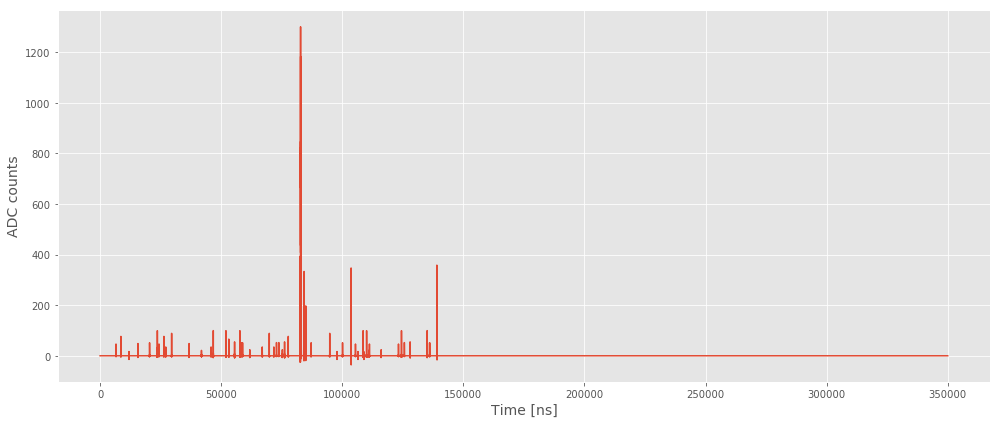

In [14]:
### Plot of waveforms for each pmt summed up

sum_waveforms = waveforms_in_channels[0].drop("event_number", axis=1).sum(axis=1)

fig = plt.figure(figsize=(14,6))
ax = plt.subplot(111)
p1 = ax.plot(sum_waveforms.index, sum_waveforms)
ax.set_xlabel("Time [ns]", size=14)
ax.set_ylabel("ADC counts", size=14)
plt.tight_layout()
# fig.savefig("recon_waveform_example.png", dpi=240)

In [16]:
event = events[0]
event.columns

Index(['baseline', 'channel', 'event_number', 'left', 'length',
       'max_waveform_length', 'right', 'waveform'],
      dtype='object')

In [ ]:
len(waveforms_in_channels[0].columns)

In [ ]:
dfc.empty()

In [ ]:
maxlist = []
for wf in waveforms_in_channels:
    df = wf[wf > 0.] #waveforms_in_channels[0]
    #df = df[df > 0.]
    for i, channel in enumerate(df):
        dfc = df[channel].dropna()
        if not dfc.empty:
            maxlist.append(dfc.max())

max(maxlist)


    #df = waveforms_in_channels[0][channel]#["channel_5"]
    #df.dropna(inplace=True)
    #df = 
    #print(df.loc[df > 0.].max())
    #max_counts[i] = df.loc[df > 0.].max()
    #print(df.loc[df > 0.].max())

#pd.Series(max_counts).dropna().max()
#df[df > 0.]["channel_0"].dropna()
#df.loc[df > 0.]

In [ ]:
len(maxlist)

In [ ]:
max_counts = np.zeros(len(waveforms_in_channels[0].columns))
for i, channel in enumerate(waveforms_in_channels[0]):
    df = waveforms_in_channels[0][channel]#["channel_5"]
    df.dropna(inplace=True)
    #df = 
    #print(df.loc[df > 0.].max())
    max_counts[i] = df.loc[df > 0.].max()
    #print(df.loc[df > 0.].max())

pd.Series(max_counts).dropna().max()
#df#.hist()
#df.max()
#df.describe()
#df.hist()

In [ ]:
df.loc[df > 0.].min()

In [ ]:
df.plot()